# Comparing Financial Instruments with Mean-Variance Analysis

This notebook uses **daily log returns** from `close.csv` to compare multiple instruments on a mean-variance (reward-risk) basis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.6f}'.format
plt.style.use('seaborn-v0_8-darkgrid')

## 1) Load Daily Close Prices

In [2]:
close_prices = pd.read_csv("close.csv", index_col="Date", parse_dates=["Date"])
close_prices.head()

,BA,BTC-USD,EURUSD=X,GC=F,MSFT,^DJI
Date,,,,,,
2014-10-01,108.406662,383.614990,1.262834,"1,214.599976",38.880169,"16,804.710938"
2014-10-02,107.971878,375.071991,1.262419,"1,214.199951",38.761570,"16,801.050781"
2014-10-03,109.876221,359.511993,1.267058,"1,192.199951",39.041100,"17,009.689453"
2014-10-04,NaN,328.865997,NaN,NaN,NaN,NaN
2014-10-05,NaN,320.510010,NaN,NaN,NaN,NaN


In [3]:
close_prices.shape, close_prices.columns.tolist()

((2434, 6), ['BA', 'BTC-USD', 'EURUSD=X', 'GC=F', 'MSFT', '^DJI'])

## 2) Initial Price Plot (Raw Levels)

Raw close-price levels are useful for a first look, but they are **not directly comparable** across assets because instruments have different units, scales, and starting prices.

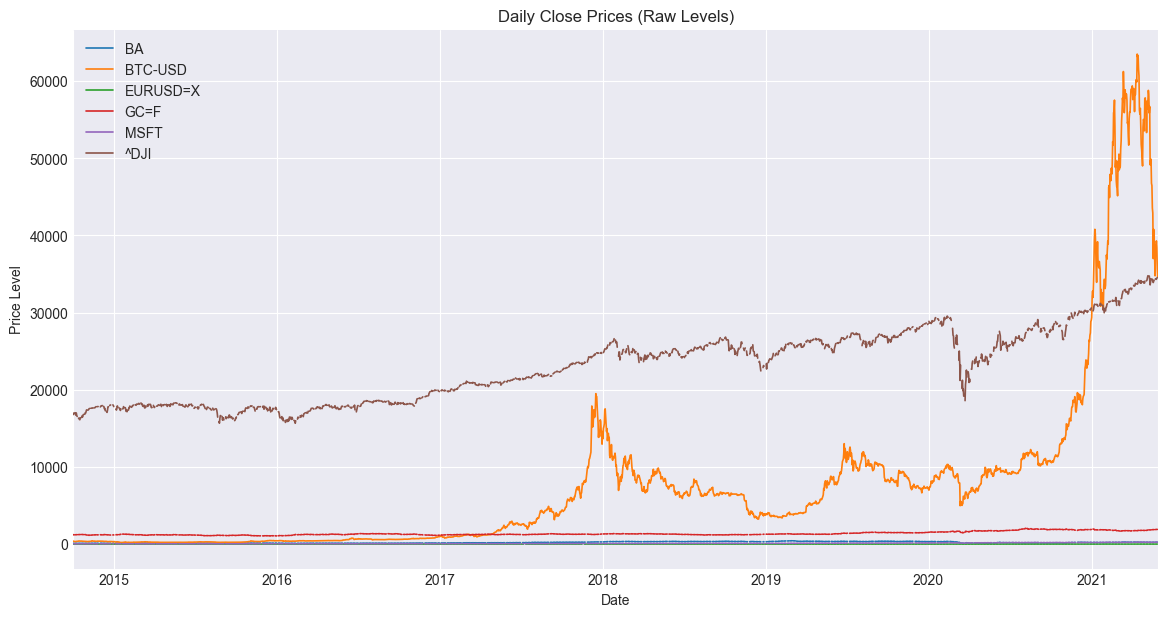

In [4]:
close_prices.plot(figsize=(14, 7), linewidth=1.2, title="Daily Close Prices (Raw Levels)")
plt.ylabel("Price Level")
plt.xlabel("Date")
plt.show()

## 3) Missing Data Problem (Different Trading Schedules)

Different markets trade on different calendars (e.g., stocks vs FX vs crypto), so missing values appear on dates where some instruments trade and others do not.

In [5]:
missing_values = close_prices.isna().sum().sort_values(ascending=False)
missing_values.to_frame(name="Missing Values")

,Missing Values
GC=F,760
BA,757
MSFT,757
^DJI,757
EURUSD=X,699
BTC-USD,0


In [6]:
close_prices[close_prices.isna().any(axis=1)].head(10)

,BA,BTC-USD,EURUSD=X,GC=F,MSFT,^DJI
Date,,,,,,
2014-10-04,NaN,328.865997,NaN,NaN,NaN,NaN
2014-10-05,NaN,320.510010,NaN,NaN,NaN,NaN
2014-10-11,NaN,362.299011,NaN,NaN,NaN,NaN
2014-10-12,NaN,378.549011,NaN,NaN,NaN,NaN
2014-10-18,NaN,391.441986,NaN,NaN,NaN,NaN
2014-10-19,NaN,389.545990,NaN,NaN,NaN,NaN
2014-10-25,NaN,347.270996,NaN,NaN,NaN,NaN
2014-10-26,NaN,354.704010,NaN,NaN,NaN,NaN
2014-11-01,NaN,325.748993,NaN,NaN,NaN,NaN


In [7]:
row_count_comparison = pd.DataFrame({
    "Metric": ["Original Rows", "Rows After Global dropna()"],
    "Value": [len(close_prices), len(close_prices.dropna())]
})

row_count_comparison

,Metric,Value
0,Original Rows,2434
1,Rows After Global dropna(),1671


To avoid throwing away too much data, we compute returns **separately per asset** after dropping NaNs for each column individually.

## 4) Create Log Returns DataFrame

Log returns are used because they are additive over time and work naturally with compounding:

`log_return_t = ln(price_t / price_(t-1))`

In [8]:
log_returns = pd.DataFrame(index=close_prices.index)

for ticker in close_prices.columns:
    asset_prices = close_prices[ticker].dropna()
    log_returns[ticker] = np.log(asset_prices / asset_prices.shift(1))

log_returns.head()

,BA,BTC-USD,EURUSD=X,GC=F,MSFT,^DJI
Date,,,,,,
2014-10-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-02,-0.004019,-0.022521,-0.000328,-0.000329,-0.003055,-0.000218
2014-10-03,0.017484,-0.042370,0.003668,-0.018285,0.007186,0.012342
2014-10-04,NaN,-0.089097,NaN,NaN,NaN,NaN
2014-10-05,NaN,-0.025737,NaN,NaN,NaN,NaN


In [9]:
log_returns.count().to_frame(name="Valid Return Observations")

,Valid Return Observations
BA,1676
BTC-USD,2433
EURUSD=X,1734
GC=F,1673
MSFT,1676
^DJI,1676


## 5) Mean and Standard Deviation of Daily Log Returns

In this framework, **mean return** is expected reward and **standard deviation** is a proxy for volatility (risk).

In [10]:
summary = log_returns.agg(["mean", "std"]).T
summary.columns = ["Mean", "Standard Deviation"]
summary = summary.sort_values(by="Standard Deviation")
summary

,Mean,Standard Deviation
EURUSD=X,-0.000020,0.005131
GC=F,0.000268,0.009395
^DJI,0.000430,0.011967
MSFT,0.001088,0.017233
BA,0.000491,0.026320
BTC-USD,0.001863,0.039476


## 6) Mean-Variance Scatter Plot

- X-axis: Standard Deviation (Risk)
- Y-axis: Mean Return (Reward)

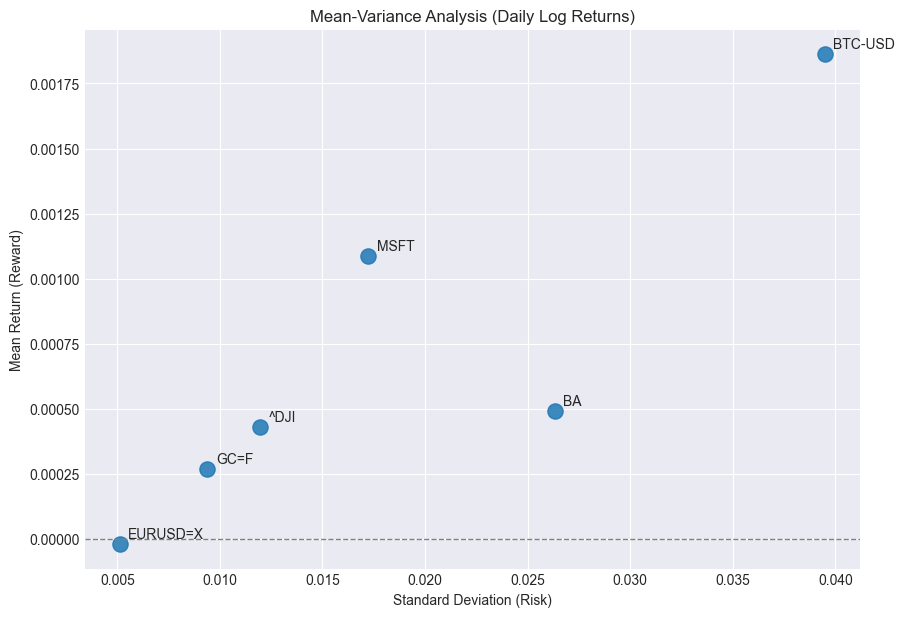

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(summary["Standard Deviation"], summary["Mean"], s=120, alpha=0.85)

for ticker in summary.index:
    ax.annotate(
        ticker,
        (summary.loc[ticker, "Standard Deviation"], summary.loc[ticker, "Mean"]),
        textcoords="offset points",
        xytext=(6, 4),
        fontsize=10
    )

ax.set_title("Mean-Variance Analysis (Daily Log Returns)")
ax.set_xlabel("Standard Deviation (Risk)")
ax.set_ylabel("Mean Return (Reward)")
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.show()

## Interpretation Notes

- **Why standard deviation is used**: it measures dispersion around the mean return, so larger values imply more day-to-day uncertainty in outcomes.
- **Normal distribution assumption**: classical mean-variance analysis implicitly treats returns as approximately normal, where mean and variance capture most of the distribution.
- **Tail-risk limitation**: real financial returns often have **fat tails** and skewness, so extreme losses happen more often than a normal model suggests. In those cases, standard deviation can underestimate downside risk.

## Final Summary

Mean-variance analysis provides a fast way to visualize the **risk-return tradeoff**: assets with higher average returns often come with higher volatility.

However, this approach is limited because it compresses each asset into only two moments (mean and standard deviation). It does not fully capture **fat tails**, regime changes, liquidity shocks, or other **extreme events** that dominate real-world portfolio risk.